In [11]:
%matplotlib inline


# Calculating xT (action-based)
Calculate action based Expected Threat once you have
found possession chains.


In [12]:
import pandas as pd
import json
# plotting
import os
import pathlib
import warnings 
from joblib import load
from mplsoccer import Pitch
from itertools import combinations_with_replacement
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [13]:
cd ~

/Users/jamesdavies


In [14]:
cd soccermatics

/Users/jamesdavies/soccermatics


## Opening the dataset

First we open the data. It is the file created in the Possesion Chain segment. The files that we open are available here
[here](https://github.com/soccermatics/Soccermatics/tree/main/course/lessons/possession_chain). There are prepared using the script
from the [previous section](https://soccermatics.readthedocs.io/en/latest/gallery/lesson4/plot_PossesionChain.html).



In [15]:
df = pd.DataFrame()
for i in range(11):
    file_name = 'possession_chains_England' + str(i+1) + '.json'
    path = os.path.join(str(pathlib.Path().resolve()), 'data', 'Wyscout',  file_name)
    with open(path) as f:
        data = json.load(f)
    df = pd.concat([df, pd.DataFrame(data)], ignore_index = True)
df = df.reset_index()

In [16]:
df[df.possesion_chain == 2].head(40)

,level_0,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,...,possesion_chain,possesion_chain_team,xG,shot_end,x0,c0,x1,c1,y0,y1
11,11,15,8,Head pass,[{'id': 1801}],8653,"[{'y': 31, 'x': 24}, {'y': 15, 'x': 42}]",2499719,Pass,1631,...,2,1631,0.0,0,25.20,12.92,44.10,23.80,46.92,57.80
12,12,16,8,Head pass,[{'id': 1801}],8013,"[{'y': 15, 'x': 42}, {'y': 26, 'x': 29}]",2499719,Pass,1631,...,2,1631,0.0,0,44.10,23.80,30.45,16.32,57.80,50.32
13,13,17,8,Simple pass,[{'id': 1801}],265366,"[{'y': 26, 'x': 29}, {'y': 8, 'x': 37}]",2499719,Pass,1631,...,2,1631,0.0,0,30.45,16.32,38.85,28.56,50.32,62.56
14,14,18,8,Simple pass,[{'id': 1801}],8013,"[{'y': 8, 'x': 37}, {'y': 5, 'x': 23}]",2499719,Pass,1631,...,2,1631,0.0,0,38.85,28.56,24.15,30.60,62.56,64.60
15,15,19,8,High pass,[{'id': 1802}],14853,"[{'y': 5, 'x': 23}, {'y': 19, 'x': 63}]",2499719,Pass,1631,...,2,1631,0.0,0,24.15,30.60,66.15,21.08,64.60,55.08
16,16,21,8,Head pass,[{'id': 1801}],14763,"[{'y': 5, 'x': 55}, {'y': 22, 'x': 67}]",2499719,Pass,1631,...,2,1631,0.0,0,57.75,30.60,70.35,19.04,64.60,53.04
17,17,22,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",12829,"[{'y': 22, 'x': 67}, {'y': 15, 'x': 71}]",2499719,Duel,1631,...,2,1631,0.0,0,70.35,19.04,74.55,23.80,53.04,57.80
18,18,24,8,Smart pass,"[{'id': 901}, {'id': 1802}]",14763,"[{'y': 15, 'x': 71}, {'y': 26, 'x': 81}]",2499719,Pass,1631,...,2,1631,0.0,0,74.55,23.80,85.05,16.32,57.80,50.32


## Preparing variables for models

For our models we will use all non-linear combinations of the starting and ending
x coordinate and *c* - distance from the middle of the pitch. We create combinations
with replacement of these variables - to get their non-linear transfomations. As the next step,
we multiply the columns in the combination and create a model with them. 

In [17]:
#model variables
var = ["x0", "x1", "c0", "c1"]

#combinations
inputs = []
#one variable combinations
inputs.extend(combinations_with_replacement(var, 1))
#2 variable combinations
inputs.extend(combinations_with_replacement(var, 2))
#3 variable combinations
inputs.extend(combinations_with_replacement(var, 3))

#make new columns
for i in inputs:
    #columns length 1 already exist
    if len(i) > 1:
        #column name
        column = ''
        x = 1
        for c in i:
            #add column name to be x0x1c0 for example
            column += c
            #multiply values in column
            x = x*df[c]
        #create a new column in df
        df[column] = x
        #add column to model variables
        var.append(column)
#investigate 3 columns
df[var[-3:]].head(3)

,c0c0c1,c0c1c1,c1c1c1
0,8.804096,246.514688,6902.411264
1,6162.867200,5502.560000,4913.000000
2,4126.920000,3466.612800,2911.954752


## Calculating action-based Expected Threat values for passes

To predict the outcome of a shot, we trained a model (XGB classifier) on Bundesliga dataset. In the code we use
model saved in the file. It was trained using *xgboost* library version 1.6.2.
Training steps are provided commented out. Using it we **predict
probability of a chain ending with a shot**. Then, on **chains that ended with a shot**, we fit a linear regression 
to calculate the **probability that a shot ended with a goal**. Product of these 2 values is our action-based Expected Threat statistic.



In [25]:
from xgboost import XGBClassifier

### TRAINING, it's not perfect ML procedure, but results in AUC 0.2 higher than Logistic Regression ###
passes = df.loc[ df["eventName"].isin(["Pass"])]
X = passes[var].values #- note that this is different X, with data from BL
y = passes["shot_end"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123, stratify = y)
xgb = XGBClassifier(
    n_estimators=100, 
    max_depth=4, 
    min_child_weight=10,  # Replace min_samples_leaf with min_child_weight
    random_state=123
)
scores = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 10, n_jobs = -1)
print(np.mean(scores), np.std(scores))
xgb.fit(X_train, y_train)
print(xgb.score(X_train, y_train))
y_pred = xgb.predict(X_test)
print(xgb.score(X_test, y_test))

0.920383290224084 0.00017419989879516136
0.9206795316351373
0.9204607601859448


In [30]:
#predict if a pass ended with shot
passes = df.loc[df["eventName"].isin(["Pass"])]
X = passes[var].values
y = passes["shot_end"].values

#path to saved model
#path_model = os.path.join(str(pathlib.Path().resolve()), 'data', 'Wyscout', 'finalized_model.sav')
#model = load(path_model) 

#predict probability of shot ended
y_pred_proba = xgb.predict_proba(X)[::,1]
passes["shot_prob"] = y_pred_proba

#OLS
shot_ended = passes.loc[passes["shot_end"] == 1]
X2 = shot_ended[var].values
y2 = shot_ended["xG"].values

lr = LinearRegression()
lr.fit(X2, y2)

#predict the likelihood of a goal from the build up play
y_pred = lr.predict(X)
passes["xG_pred"] = y_pred

#calculate xGchain
passes["xT"] = passes["xG_pred"]*passes["shot_prob"]

passes[["xG_pred", "shot_prob", "xT"]].head(10)

,xG_pred,shot_prob,xT
0,0.121099,0.035804,0.004336
1,0.108244,0.042915,0.004645
2,0.121571,0.044241,0.005378
3,0.118808,0.031893,0.003789
4,0.116028,0.046093,0.005348
5,0.083610,0.177031,0.014802
7,0.069977,0.093278,0.006527
8,0.087272,0.065989,0.005759
9,0.092194,0.067559,0.006229
10,0.089549,0.118735,0.010633


In [28]:
! xg_boost --version

zsh:1: command not found: xg_boost


In [ ]:
passes[passes['possesion_chain'] == 1][['xG_pred', 'xT', 'shot_prob', 'xG']]

## Making a plot of pass values

Now we can make the plot of the pass. This is the same plot as we have seen in 
[previous section](https://soccermatics.readthedocs.io/en/latest/gallery/lesson4/plot_PossesionChain.html) but this time
the value is assigned to passes and line width is proportional to its value.



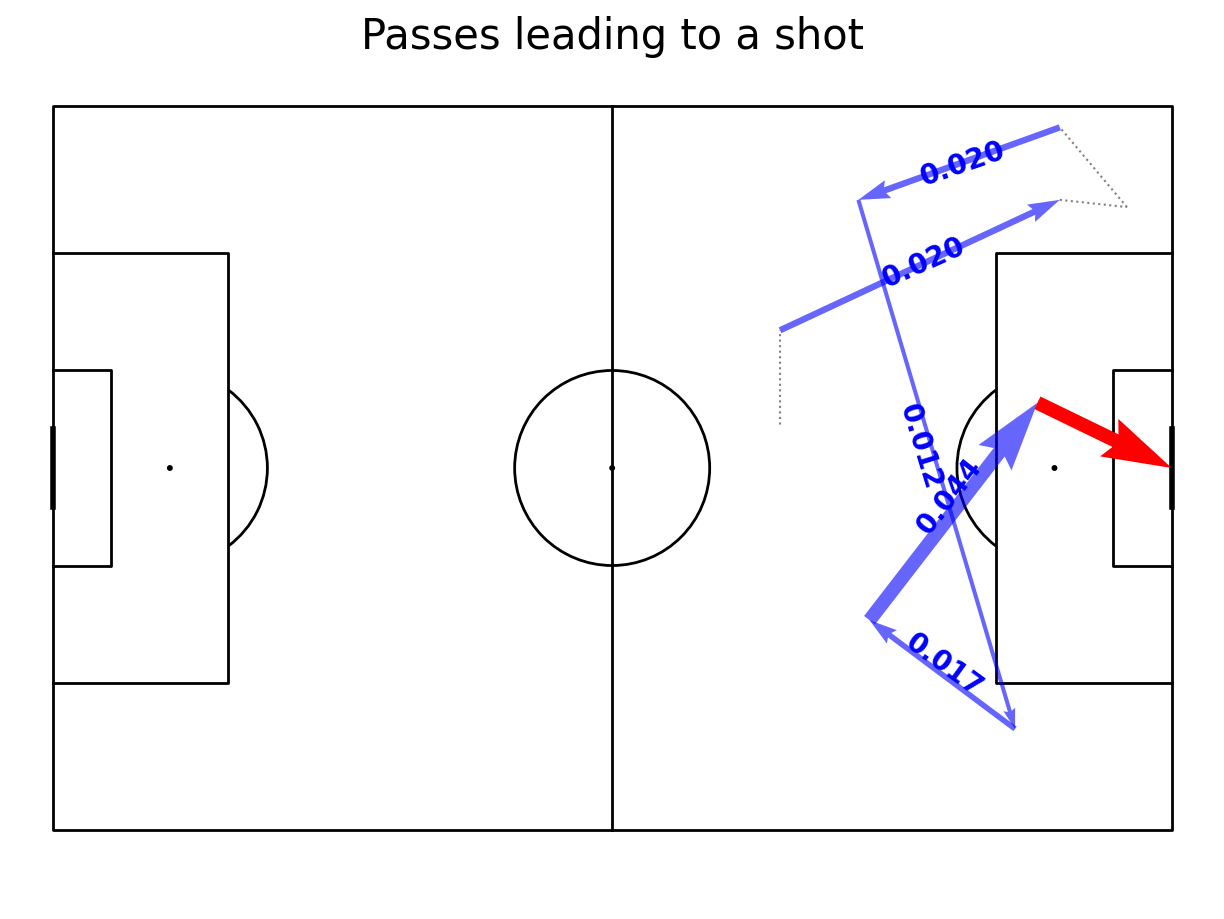

In [31]:
chain = df.loc[df["possesion_chain"] == 4]

#get passes
passes_in = passes.loc[df["possesion_chain"] == 4]
max_value = passes_in["xT"].max()
#get events different than pass
not_pass = chain.loc[chain["eventName"] != "Pass"].iloc[:-1]

#shot is the last event of the chain (or should be)
shot = chain.iloc[-1]
#plot 
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#add size adjusted arrows
for i, row in passes_in.iterrows():
    value = row["xT"]
    
    #adjust the line width so that the more passes, the wider the line
    line_width = (value / max_value * 10)
    
    #get angle
    angle = np.arctan((row.y1-row.y0)/(row.x1-row.x0))*180/np.pi
    
    #plot lines on the pitch
    pitch.arrows(row.x0, row.y0, row.x1, row.y1,
                        alpha=0.6, width=line_width, zorder=2, color="blue", ax = ax["pitch"])
    #annotate text
    ax["pitch"].text((row.x0+row.x1-8)/2, (row.y0+row.y1-4)/2, str(value)[:5], fontweight = "bold", color = "blue", zorder = 4, fontsize = 20, rotation = int(angle))

#shot
pitch.arrows(shot.x0, shot.y0,
            shot.x1, shot.y1, width=line_width, color = "red", ax=ax['pitch'], zorder =  3)

#other passes like arrows
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, color = "grey", lw = 1.5, ls = 'dotted', ax=ax['pitch'])
ax['title'].text(0.5, 0.5, 'Passes leading to a shot', ha='center', va='center', fontsize=30)
plt.show()

## Finding out players with highest action-based Expected Threat
As the last step we want to find out which players who played more than 400 minutes
scored the best in possesion-adjusted action-based Expected Threat per 90. We repeat steps that you already know 
from [Radar Plots](https://soccermatics.readthedocs.io/en/latest/gallery/lesson3/plot_RadarPlot.html).
We group them by player, sum, assign merge it with players database to keep players name,
adjust per possesion and per 90. Only the last step differs, since we stored *percentage_df*
in a .json file that can be found [here](https://github.com/soccermatics/Soccermatics/tree/main/course/lessons/minutes_played).



In [32]:
summary = passes[["playerId", "xT"]].groupby(["playerId"]).sum().reset_index()
#add player name
path = os.path.join(str(pathlib.Path().resolve()),"data", 'Wyscout', 'players.json')
player_df = pd.read_json(path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
to_merge = player_df[['playerId', 'shortName', 'role']]

summary = summary.merge(to_merge, how = "left", on = ["playerId"])

#get minutes
path = os.path.join(str(pathlib.Path().resolve()),"data", 'Wyscout', 'minutes_played_per_game_England.json')
with open(path) as f:
    minutes_per_game = json.load(f)
#filtering over 400 per game
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]
#calculating per 90
summary["xT_p90"] = summary["xT"]*90/summary["minutesPlayed"]

#adjusting for possesion
path = os.path.join(str(pathlib.Path().resolve()),"data", 'Wyscout', 'player_possesion_England.json')
with open(path) as f:
    percentage_df = json.load(f)
percentage_df = pd.DataFrame(percentage_df)
#merge it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])
#adjust per possesion
summary["xT_adjusted_per_90"] = (summary["xT"]/summary["possesion"])*90/summary["minutesPlayed"]
summary[['shortName', 'xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90', ascending=False).head(5)

,shortName,xT_adjusted_per_90
22,M. Özil,1.517753
27,Fàbregas,1.426529
250,E. Hazard,1.373377
30,A. Sánchez,1.346957
117,David Silva,1.310881


In [36]:
percentage_df[percentage_df.playerId == 7936]	

,playerId,possesion
131,7936,0.568005


## Challenge
1. StatsBomb has recently released a dataset with Indian Superleague 2021/22 games. Calculate
xGchain values for these player. Note that the possesion chains are already isolated. Which player stood out the most? 

